In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix, accuracy_score
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
plt.style.use('seaborn-white')

### 1.loading the dataset

In [325]:
multiclass = pd.read_csv(r'C:\Users\Fra\Documents\SDS\SML\DATASET PROGETTO\multiclass_dataset_no_weird_obs.csv',header= 0)

In [326]:
first_split, second_split = train_test_split (multiclass, test_size=403,
                                              train_size=604, random_state=42,
                                              shuffle=True, stratify=None,
)

In [322]:
Training, Test = train_test_split(first_split, train_size = 480,
                                   test_size = 124, random_state=42,
                                   shuffle=True, stratify=None,
)

In [327]:
y_test = Test.iloc[:,17395]
x_train = np.array(Training.drop(['label','Unnamed: 0','DepMap_ID'], axis = 1))
y_train = Training.iloc[:,17395]
x_test = np.array(Test.drop(['label','DepMap_ID','Unnamed: 0'], axis = 1))

In [328]:
y_train

868    6
626    0
58     0
297    0
458    0
      ..
954    0
383    3
419    8
217    6
680    7
Name: label, Length: 480, dtype: int64

### 2.Random Forest with the same parameters as in the RF.blood model

In [294]:
rf = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    min_samples_leaf = 4, n_estimators = 504,
                    min_samples_split= 10, max_leaf_nodes= 35,
                    max_depth = 48, class_weight = "balanced",
                    bootstrap = True, oob_score = True)

In [295]:
rf.fit(x_train, y_train)
print('Training score: ', rf.score(x_train, y_train))
print('Test score: ', rf.score(x_test, y_test))

Training score:  1.0
Test score:  0.6451612903225806


In [296]:
y_pred = rf.predict(x_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

The accuracy of the model is 64.5 %


In [297]:
#Create the vectors that contains the Cancers chosen (Cancer_Type2) and the one observed (Cancer_Type)
Cancer_Type = ["Gastrointestinal","Genitals","Muscle-Bone","Neuro","Breast","Head_Neck","Blood",
               "Genitourinary", "Lung"] 

In [298]:
#Change the name of the coloumns of the class matrix created through get_dummies using more meaningful names
y_test_dummies = pd.get_dummies(y_test).set_axis(Cancer_Type, axis = 1)
y_pred_dummies = pd.get_dummies(y_pred, dummy_na= True).T.reindex(range(9)).T.fillna(0)
y_pred_dummies = y_pred_dummies.set_axis(Cancer_Type, axis= 1)

In [299]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                fontsize = 15,
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

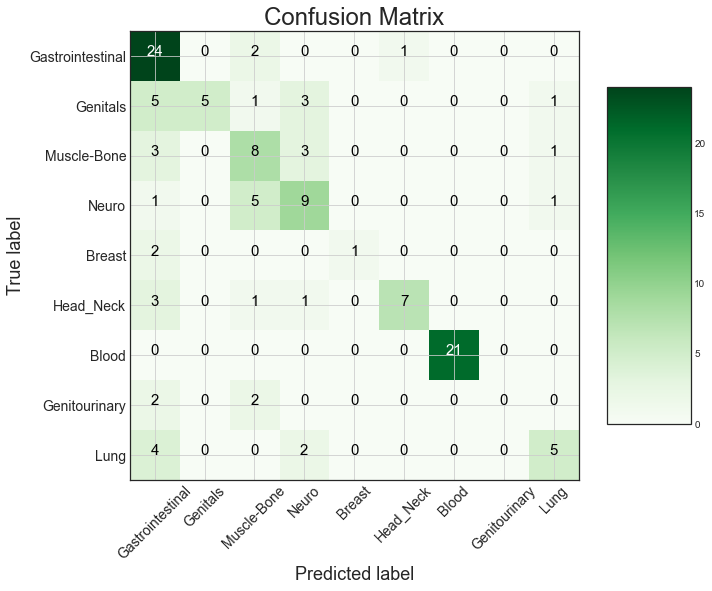

In [300]:
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')

### A model with different class weights

In [329]:
#let us compute the class frequencies loooking for some clues for balancing in a different way the classes
y_train_dummies = pd.get_dummies(y_train).set_axis(Cancer_Type, axis = 1)
y_train_dummies.sum()

Gastrointestinal    103
Genitals             42
Muscle-Bone          64
Neuro                65
Breast               23
Head_Neck            37
Blood                52
Genitourinary        33
Lung                 61
dtype: int64

In [330]:
rf_class_weighted = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    min_samples_leaf = 4, n_estimators = 504,
                    min_samples_split= 10, max_leaf_nodes= 35,
                    max_depth = 48, class_weight={0:1,1:3,2:1.6,3:1.6,4:10,5:4,6:2,7:5,8:2},
                    bootstrap = True, oob_score = True)

#class_weight={0:1,1:3,2:1.6,3:1.6,4:10,5:3,6:2,7:2,8:2}, Test score:  0.6774193548387096
#class_weight={0:1,1:3,2:1.6,3:1.6,4:10,5:4,6:2,7:5,8:2}, Test score:  0.6693548387096774 almeno 1 in tutte le classi!

In [331]:
rf_class_weighted.fit(x_train, y_train)
print('Training score: ', rf_class_weighted.score(x_train, y_train))
print('Test score: ', rf_class_weighted.score(x_test, y_test))

Training score:  1.0
Test score:  0.6693548387096774


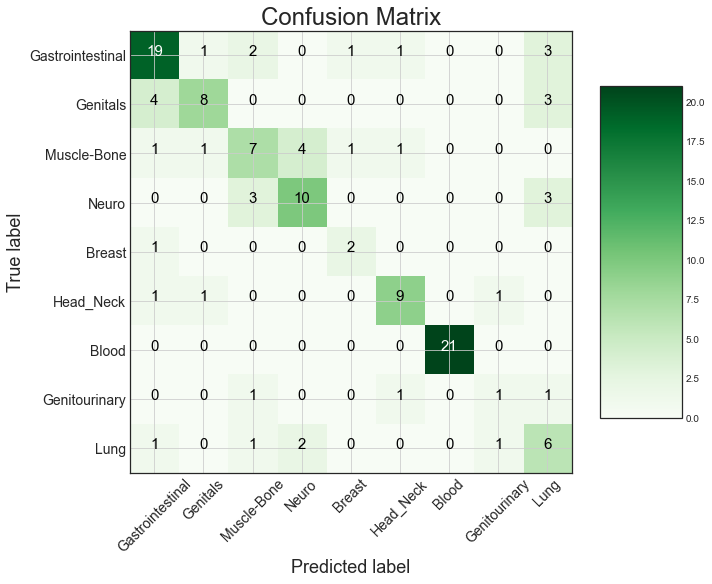

In [332]:
y_pred = rf_class_weighted.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')

### Selection of the important features

In [333]:
out = cross_validate(rf_class_weighted, x_train, y_train, cv = 5, n_jobs = -1,
                scoring = 'accuracy', return_estimator = True)

In [335]:
x_train_feature_impo = Training.drop(['label','Unnamed: 0','DepMap_ID'], axis = 1)

feat_impo_all = []
for i, estimator in enumerate(out['estimator']):
    print("First 10 features sorted by their importance for model n. {}:".format(i+1))
    feat_impo = pd.DataFrame(estimator.feature_importances_,
                            index = x_train_feature_impo.columns,
                            columns = ['Importance{}'.format(i+1)]).sort_values('Importance{}'.format(i+1), ascending = False)
    print(feat_impo[:10])
    print('--------------------------------')

    feat_impo_all.append(feat_impo[feat_impo['Importance{}'.format(i+1)] > 0.001])
    
    
    
#altro metodo per feat_impo
# pd.DataFrame(out['estimator'][1].feature_importances_,
#                             index = x_train_feature_impo.columns,
#                             columns = ['Importance'.format(i+1)]).where(lambda x : x > 0.0005).dropna().index

First 10 features sorted by their importance for model n. 1:
               Importance1
PAX8..7849.       0.002541
ZEB2..9839.       0.001861
MYB..4602.        0.001847
ATP1B3..483.      0.001684
ILK..3611.        0.001592
HPRT1..3251.      0.001591
TP63..8626.       0.001575
IKZF1..10320.     0.001564
IFI30..10437.     0.001526
SOX10..6663.      0.001416
--------------------------------
First 10 features sorted by their importance for model n. 2:
                  Importance2
IKZF1..10320.        0.002992
ZEB2..9839.          0.002104
HPRT1..3251.         0.002074
TRPS1..7227.         0.002000
PAX8..7849.          0.001976
RORB..6096.          0.001865
FOXA1..3169.         0.001434
KCMF1..56888.        0.001366
SPDEF..25803.        0.001360
C12orf29..91298.     0.001327
--------------------------------
First 10 features sorted by their importance for model n. 3:
               Importance3
ZEB2..9839.       0.002269
IKZF1..10320.     0.002179
ILK..3611.        0.002109
PAX8..7849.     

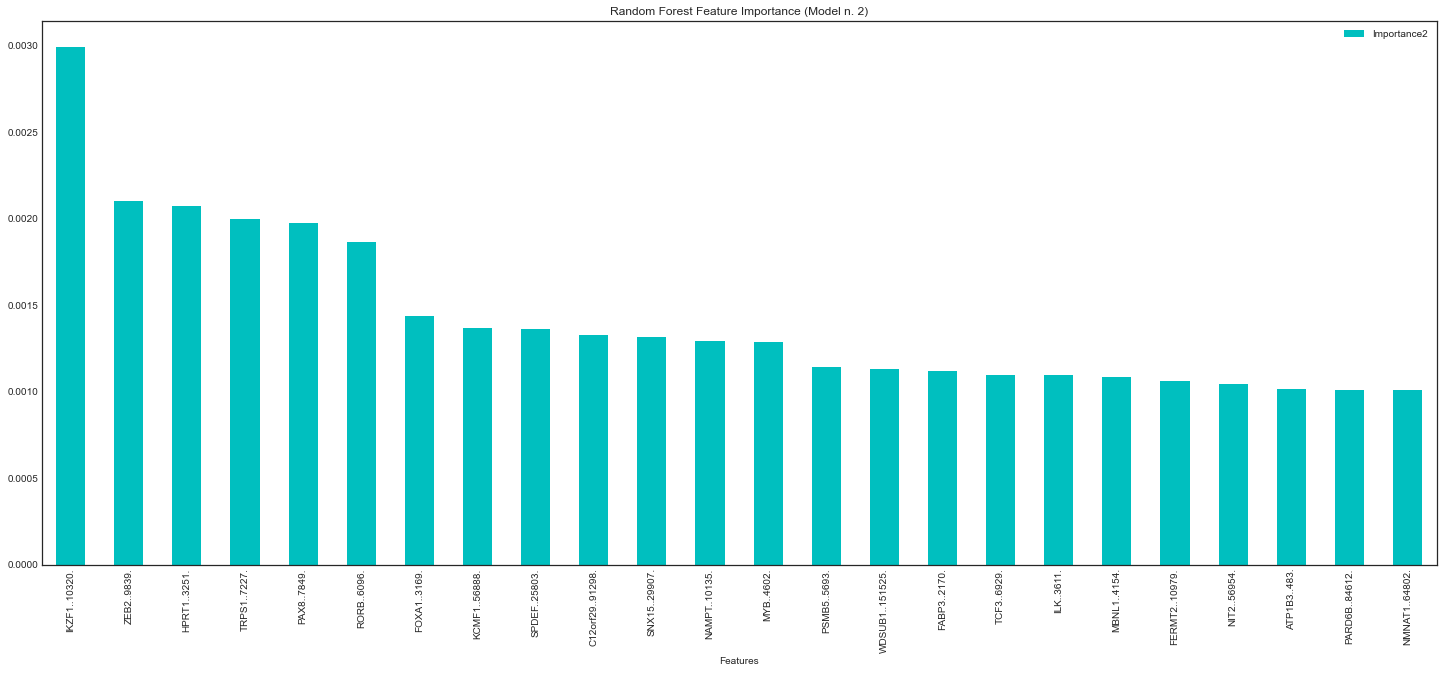

In [336]:
feat_impo_all[1].plot.bar(figsize = (25, 10), color = 'c')
plt.title('Random Forest Feature Importance (Model n. 2)')
plt.xlabel('Features')
plt.show()

### New model using the remaining features

In [357]:
important_features = feat_impo_all[3] #circa 300 features
genes = important_features.drop(['Importance4'], axis = 1).index
genes

Index(['ZEB2..9839.', 'SPDEF..25803.', 'IKZF1..10320.', 'CBFB..865.',
       'MBNL1..4154.', 'PAX8..7849.', 'MYB..4602.', 'POU2AF1..5450.',
       'STARD8..9754.', 'TRPS1..7227.', 'TP63..8626.', 'RPL32..6161.',
       'NCKAP1..10787.', 'NMNAT1..64802.', 'ARHGAP45..23526.', 'FOXA1..3169.',
       'MKNK1..8569.', 'CDK6..1021.'],
      dtype='object')

In [358]:
Training2, Test2 = train_test_split(second_split, train_size = 320,
                                   test_size = 83, random_state=42,
                                   shuffle=True, stratify=None,
)

In [359]:
y_test_2 = Test2.iloc[:,17395]
x_train_2 = np.array(Training2.filter(genes, axis = 1))
y_train_2 = Training2.iloc[:,17395]
x_test_2 = np.array(Test2.filter(genes,axis = 1))

In [360]:
#balanced RF

rf.fit(x_train_2, y_train_2)
print('Training score: ', rf.score(x_train_2, y_train_2))
print('Test score: ', rf.score(x_test_2, y_test_2))

Training score:  0.93125
Test score:  0.5060240963855421


In [361]:
#Same class weights as in the training

rf_class_weighted.fit(x_train_2, y_train_2)
print('Training score: ', rf_class_weighted.score(x_train_2, y_train_2))
print('Test score: ', rf_class_weighted.score(x_test_2, y_test_2))

Training score:  0.928125
Test score:  0.4578313253012048


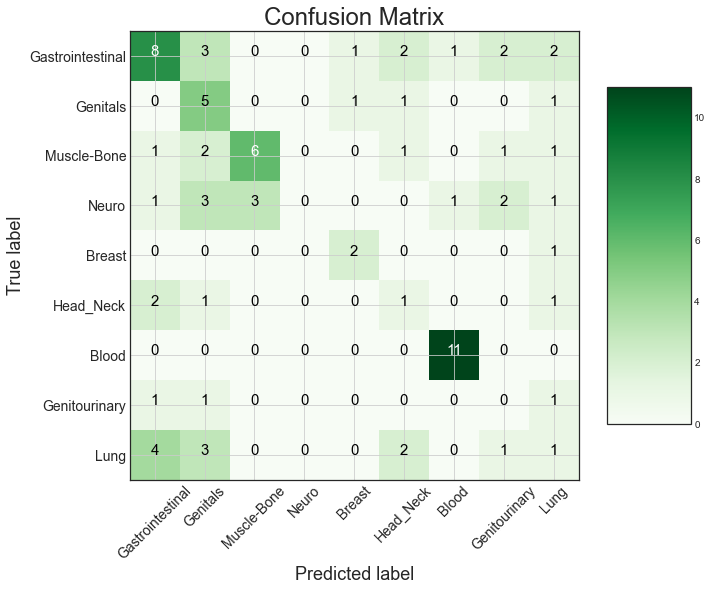

In [344]:
#Change the name of the coloumns of the class matrix created through get_dummies using more meaningful names
y_test_dummies = pd.get_dummies(y_test_2).set_axis(Cancer_Type, axis = 1)

y_pred = rf_class_weighted.predict(x_test_2)
y_pred_dummies = pd.get_dummies(y_pred, dummy_na= True).T.reindex(range(9)).T.fillna(0)
y_pred_dummies = y_pred_dummies.set_axis(Cancer_Type, axis= 1)

cm = confusion_matrix(y_test_2,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')